In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [2]:
r = requests.get('https://api.covid19api.com/dayone/country/morocco')
res=r.json()
df=pd.DataFrame(res)
#df.to_csv('ma.csv',index=False)
c=np.array(df['Confirmed'])
a=np.array(df['Active'])
r=np.array(df['Recovered'])
d=np.array(df['Deaths'])
N=np.max(c)
s=N-a-r-d
p=1
print(np.max(s))
print(N,a.shape[0])


7921
7922 94


In [3]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma):
    S, I, R , D = y
    dSdt = -beta * I *(S/ N)**p
    dIdt = beta * I * (S/ N)**p - (gamma +sigma) * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt


#Test de la fonction deriv
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1)


(-0.0012623074981065387, -0.2987376925018935, 0.2, 0.1)

In [4]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma)).T

In [5]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n)
    I=np.empty(n)
    R=np.empty(n)
    D=np.empty(n)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n-1):
        root=np.sqrt((tau*(gamma+sigma)+1-tau*(beta/N)*(S[k]+I[k]))**2+4.*tau*(beta/N)*(tau*(gamma+sigma)+1.)*I[k])
        rest=(tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k]))
        den=(2.*tau*(beta/N)*(1.+tau*(gamma+sigma)))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[0:-1].tolist()
    I=I[0:-1].tolist()
    R=R[0:-1].tolist()
    D=D[0:-1].tolist()
    return np.array([S,I,R,D])
        
    

In [17]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n)
    I=np.empty(n)
    R=np.empty(n)
    D=np.empty(n)
    P[:15]=np.ones(n)
    P[15:]=np.ones(n)*2
    print("pppppppp",p)
    #P[16:]=1.2
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=(S[0]/N)**(P[0]-1)
    for k in range(n-1):
        Err=1
        II=I[k]
        while Err>0.0001:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k])
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))
            III=(root -rest)/den
            SS=S[k]/(1.+tau*(beta/N)*III*theta)
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta=(SS/N)**(P[k+1]-1)
            Err=abs(II-III)
            II=III
            print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

N: 7922
pppppppp 2
0.14665133052495039
2.4818844496676817e-05
0.1681216104588179
3.2628086627628505e-05
0.19272431264782441
4.289160159376415e-05
0.22091301232092642
5.637925796930787e-05
0.2532058816453189
7.410164166210542e-05
0.29019454804912703
9.738502127998316e-05
0.33255405840766716
0.00012796930688363517
0.38105405158094774
0.00016813627205580772
0.4365712385256435
0.0002208769918459197
0.5001032803331555
0.0002901103995949228
0.5727841373686196
0.0003809682173807616
0.6559009342769695
0.0005001659185959184
0.7509123418710244
0.0006564849651429228
0.8594684126874936
0.0008613985585217421
0.9834317159472041
0.0011298820595744274
3.083958999283709e-07
1.1248995356295977
0.0014814600623509477
4.6296645273002923e-07
1.2862264842523086
0.0019415551637820272
6.945255464074762e-07
1.4700471976856555
0.0025432206982287653
1.0410616617662072e-06
1.6792978140660466
0.003329357742488881
1.5590955602107215e-06
1.9172350042700668
0.004355539798204688
2.3324810864977508e-06
2.187450653850916

1.012936161980287e-08
9.033475292760277e-09
8.058979451174716e-09
7.185642347470015e-09
6.4100920237167955e-09
5.715468690268257e-09
5.098400389195055e-09
4.5487712467090725e-09
4.056465389022254e-09
3.618110858205221e-09
3.2269637383992458e-09
2.8796520716749832e-09
2.566059984244334e-09
2.289559434036667e-09
2.0400345472638923e-09
1.8208572818553758e-09
1.6252837219523899e-09
1.4465699516962156e-09
1.2914598869455704e-09
1.1532096118417384e-09
1.0284471684553512e-09
9.171725567864102e-10
8.160138189055578e-10
7.2834291274215e-10
6.50787880366829e-10
5.799767638502304e-10
5.192815211217186e-10
4.585862783932051e-10
4.1137886738214046e-10
3.67543414300437e-10
3.270799191480951e-10
2.899883819251156e-10
2.6301271849022087e-10
2.3266509712596455e-10
2.0568943369107023e-10
1.8545768611489928e-10
1.6522593853872854e-10
1.4836614889191939e-10
1.3150635924511044e-10
1.1464656959830148e-10
1.0453069581021591e-10
9.441482202213064e-11
8.429894823404517e-11
7.418307444595969e-11
6.4067200657874

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


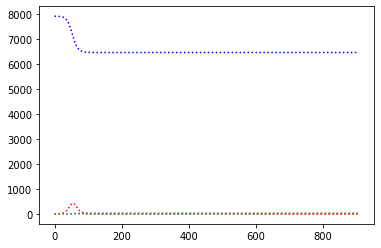

In [15]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('beta', value=1.3, min=0, max=4.0)
fit_params.add('gamma', value=0.02, min=0, max=1.0)
fit_params.add('sigma', value=0.001, min=0, max=1.0)

N=fit_params['N'].value
print('N:',N)


#Test de f
x=np.linspace(1,92,910)
#x=np.linspace(1,2,10)
y0=[N-1,1,0,0]

data=np.array([s[1:],a[1:],r[1:],d[1:]])

## Plot real data
#plt.plot(data[0],label="Sr", color='blue')
#plt.plot(data[1],label="Ar", color='red')
#plt.plot(data[2],label="Rr", color='green')
#plt.plot(data[3],label="Dr", color='gray')
p=2
#y=f(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
#plt.plot(y[1], label="Is",color='red')
#plt.plot(y[2],label="Rs", color='green')
#plt.plot(y[3],label="Ds", color='gray')


yf=fahdFix(fit_params,x,y0)
#Plot estimated data using Mr karami's Algorithm
plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')

#plt.legend()


In [8]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    for i in range(ndata):
        resid[i, :] = data[i, :] - ret[i,:]
    #resid=data[0, :] - ret[0,:]
    return resid.flatten()

In [9]:
y0=[N-1,1,0,0]
out = minimize(objective, fit_params,  args=(f,x,data,y0))
outf = minimize(objective, fit_params,  args=(fahdFix,x,data,y0))

report_fit(out.params)
report_fit(outf.params)
y=f(out.params,x,[N-1,1,0,0])
yf=fahd(outf.params,x,[N-1,1,0,0])

## Plot real data
plt.plot(data[0],label="Sr", color='blue')
plt.plot(data[1],label="Ir", color='red')
plt.plot(data[2],label="Rr", color='green')
plt.plot(data[3],label="Dr", color='gray')

#Plot estimated data using odint
plt.plot(y[0], label="Sr",linestyle='dashed',color='blue')
plt.plot(y[1], label="Is",linestyle='dashed',color='red')
plt.plot(y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(y[3],label="Ds",linestyle='dashed', color='gray')

#Plot estimated data using Mr karami's Algorithm
plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')


plt.legend()


ValueError: operands could not be broadcast together with shapes (93,) (910,) 

In [ ]:

#hadi ca pourra t aider elle prend que les element qui nous interesse 
npArray = np.arange(1,int((a.shape[0]-1)/tau) , int(1/tau))
yyy=X[npArray]